In [ ]:
#@title 必要なライブラリのインストール

!pip install -q ultralytics
!git clone https://github.com/edihbrandon/RictyDiminished.git

import colorsys
import os
import random
import re

import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageFont
from pydantic import BaseModel
from tqdm.notebook import tqdm
from ultralytics import YOLO

fatal: destination path 'RictyDiminished' already exists and is not an empty directory.


In [ ]:
#@title Google Driveに接続

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


下記のURLから動画ファイルをダウンロードしてください。サイズは1280×720にしてください。ダウンロード後、Google Colabにアップロードしてください。



**[動画のURL](https://pixabay.com/ja/videos/%E5%85%AC%E5%9C%92-%E4%BA%BA-%E3%83%9C%E3%82%B1-%E3%81%BC%E3%81%8B%E3%81%97-6390/)**


> <a href="https://pixabay.com/ja//?utm_source=link-attribution&utm_medium=referral&utm_campaign=video&utm_content=6390">Pixabay</a>が提供する<a href="https://pixabay.com/ja/users/coverr-free-footage-1281706/?utm_source=link-attribution&utm_medium=referral&utm_campaign=video&utm_content=6390">Coverr-Free-Footage</a>の動画



In [ ]:
video_dir = "/content/drive/MyDrive/Pixabay" # @param {type:"string"}
video_filename = "6390-191704476_medium.mp4" # @param {type:"string"}

In [ ]:
#@title Configオブジェクト（設定値を格納するオブジェクト）

class Config(BaseModel):
    video_dir: str
    video_filename: str

    @property
    def video_src_path(self):
        return os.path.join(self.video_dir, self.video_filename)

In [ ]:
#@title BBoxの定義

PATH_FONT = "/content/RictyDiminished/RictyDiminishedDiscord-Regular.ttf"
FONT_CACHE: dict[int, ImageFont.FreeTypeFont] = {}
CHAR_CACHE: dict[str, dict[int, tuple[bool, tuple[int, int, int, int], np.ndarray]]] = {}
DEFAULT_TEXT_COLOR = (0, 0, 255)
DEFAULT_PADDING_TOP = 20
TEXT_OFFSET = 5

class BBox(BaseModel):
    left: float
    top: float
    right: float
    bottom: float
    score: float
    label: int

    @property
    def bottom_center(self) -> tuple[float, float]:
        return ((self.left + self.right) / 2, self.bottom)

    def draw(self, img: np.ndarray, classnames: dict[int, str], color_mapping: dict[str, tuple[int, int, int]], alert: bool, another_text_list: list[tuple[str, tuple[int, int, int]]]):
        color = (DEFAULT_TEXT_COLOR if alert else color_mapping.get(classnames[self.label], DEFAULT_TEXT_COLOR))

        # Draw bounding box
        cv2.rectangle(
            img,
            pt1=(int(self.left), int(self.top)),
            pt2=(int(self.right), int(self.bottom)),
            color=color,
            thickness=2,
        )

        # Draw label text
        self._put_text(img, classnames.get(self.label, 'not found'), color, 0)

        # Draw additional texts
        padding_top = DEFAULT_PADDING_TOP
        for text, text_color in another_text_list:
            padding_top += self._put_text(img, text, text_color, padding_top)

    def _put_text(self, img: np.ndarray, text: str, color: tuple[int, int, int], padding_top: int) -> int:
        text = re.sub(r"[\t\n\r]", "", text)
        h, w, *_ = img.shape
        d = img.ndim
        offset = TEXT_OFFSET
        max_height = 0

        for char in text:
            jp, bbox, mask = self._get_char_mask(char, size=20)
            li, ti, ri, bi = (
                int(self.left) + bbox[0] + offset,
                int(self.top) + bbox[1] + padding_top,
                int(self.left) + bbox[2] + offset,
                int(self.top) + bbox[3] + padding_top,
            )

            offset += bbox[2] - bbox[0]
            max_height = max(max_height, bbox[3] - bbox[1])

            # Adjust clipping
            lm, tm, rm, bm = 0, 0, ri - li, bi - ti
            li, lm = max(0, li), lm - min(0, li)
            ti, tm = max(0, ti), tm - min(0, ti)
            ri, rm = min(w, ri), rm - max(0, ri - w)
            bi, bm = min(h, bi), bm - max(0, bi - h)

            if (ri - li) <= 0 or (bi - ti) <= 0:
                continue

            # Apply mask to image
            if d == 3:
                img[ti:bi, li:ri] = img[ti:bi, li:ri] * (1 - mask[tm:bm, lm:rm, np.newaxis]) + color * mask[tm:bm, lm:rm, np.newaxis]
            else:
                img[ti:bi, li:ri] = img[ti:bi, li:ri] * (1 - mask[tm:bm, lm:rm]) + color * mask[tm:bm, lm:rm]

        return max_height

    @staticmethod
    def _get_char_mask(char: str, size: int):
        def _get_font(size: int) -> ImageFont.FreeTypeFont:
            if size not in FONT_CACHE:
                FONT_CACHE[size] = ImageFont.truetype(PATH_FONT, size)
            return FONT_CACHE[size]

        if char not in CHAR_CACHE:
            CHAR_CACHE[char] = {}

        if size not in CHAR_CACHE[char]:
            font = _get_font(size)
            bbox = font.getbbox(char)
            mask = np.asarray(font.getmask(char, "L"), dtype=np.float32).reshape(bbox[3] - bbox[1], bbox[2] - bbox[0]) / 255
            CHAR_CACHE[char][size] = (not char.isascii(), bbox, mask)

        return CHAR_CACHE[char][size]

In [ ]:
#@title Maskの定義

class Mask:
    def __init__(self, mask: np.ndarray):
        self.mask: np.ndarray = mask

    def draw(self, img: np.ndarray, label, classnames, color_mapping, alpha=0.5) -> np.ndarray:
        color = color_mapping[classnames[label]]
        return self._apply_mask(img, color, alpha)


    def _apply_mask(self, img: np.ndarray, color: tuple[int, int, int], alpha=0.5) -> np.ndarray:
        for c in range(3):  # RGBの各チャンネルに対して
            img[:, :, c] = np.where(self.mask == 1, img[:, :, c] * (1 - alpha) + alpha * color[c], img[:, :, c])

In [ ]:
#@title Detectionオブジェクト（結果を格納するオブジェクト）


class Detection:
    def __init__(self, bbox: BBox, mask: Mask):
        self.bbox: BBox = bbox
        self.mask: Mask = mask
        self.alert = False
        self.another_text_list = []


    def draw(self, img, classnames, color_mapping):
        """Bounding boxとSkeletonを描画するメソッド"""
        self.bbox.draw(img, classnames, color_mapping, self.alert, self.another_text_list)

        if isinstance(self.mask, Mask):
            self.mask.draw(img, self.bbox.label, classnames, color_mapping)

    @classmethod
    def postprocess(cls, result) -> "Detection":
        """推論結果を受け取り、Detectionインスタンスを生成する"""
        bbox = cls._create_bbox(result)
        mask = cls._create_mask(result) if result.masks is not None else None
        return cls(bbox, mask)

    @staticmethod
    def _create_bbox(result) -> BBox:
        """Bboxオブジェクトを生成"""
        xyxy = result.boxes.xyxy.cpu().numpy()[0]
        return BBox(
            left=int(xyxy[0]),
            top=int(xyxy[1]),
            right=int(xyxy[2]),
            bottom=int(xyxy[3]),
            score=float(result.boxes.conf.cpu().numpy()[0]),
            label=int(result.boxes.cls.cpu().numpy()[0])
        )


    @staticmethod
    def _create_mask(result) -> Mask:
        """Maskオブジェクトを生成"""
        shape = result.orig_shape
        return Mask(
                cv2.resize(result.masks.data.cpu().numpy()[0], (shape[1], shape[0]), interpolation=cv2.INTER_NEAREST)
            )

In [ ]:
#@title Driftingオブジェクト（フレームごとの結果を保存するオブジェクト）

class Drifting:
    def __init__(self, img, count, detections = []):
        self.img: np.ndarray = img
        self.result_img: np.ndarray = img.copy()
        self.count: int = count
        self.detections: list[Detection] = detections

In [ ]:
#@title 動画読み込みエレメント

class VideoSrc:
    def __init__(self, config: Config):
        self.frame_num = 0
        self.video_src_path = config.video_src_path
        self.cap = cv2.VideoCapture(self.video_src_path)
        self.frame_count = int(self.cap.get(cv2.CAP_PROP_FRAME_COUNT))
        self.fps = round(self.cap.get(cv2.CAP_PROP_FPS))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))

    def read(self) -> Drifting | None:
        _, img = self.cap.read()

        if _ is False:
            return None

        drifting = Drifting(
            img,
            self.frame_num,
            []
        )
        print(f"\rcount: {self.frame_num} / {self.frame_count}", end="")
        self.frame_num += 1
        return drifting

    def reload(self):
        self.cap = cv2.VideoCapture(self.video_src_path)
        self.frame_num = 0

    def release(self):
        self.frame_num = 0
        self.cap.release()

In [ ]:
#@title 動画書き込みエレメント

class VideoSink:
    def __init__(self, src: VideoSrc):
        self.output_path = self.generate_output_path(src.video_src_path)
        fmt = cv2.VideoWriter_fourcc("m","p","4","v")
        frame_rate = src.fps
        size = (src.width, src.height)
        self.writer = cv2.VideoWriter(self.output_path, fmt, frame_rate, size)

    def write(self, drifting: Drifting) -> Drifting:
        self.writer.write(drifting.result_img)
        return drifting

    def release(self):
        self.writer.release()

    @staticmethod
    def generate_output_path(file_path: str) -> str:
        file_name_without_ext, _ = os.path.splitext(file_path)
        new_file_path = f"{file_name_without_ext}_out.mp4"
        return new_file_path

In [ ]:
#@title セグメンテーションエレメント

class SegmentationClassifier:
    def __init__(self, conf=0.25):
        self.model = YOLO('yolov8m-seg.pt')
        self.classnames = self.model.names
        self.confidence_threshold = conf

    def predict(self, drifting: Drifting) -> Drifting:
        results = self.model.predict(drifting.img, conf=self.confidence_threshold)
        drifting.detections += [Detection.postprocess(result) for result in results[0]]
        return drifting

In [ ]:
#@title 結果の描画エレメント

class DetectionRenderer:
    def __init__(self, classnames, bg_img = None):
        self.GOLDEN_RATIO = 0.618033988749895
        self.classnames = classnames
        self.color_mapping = {
            element: (0, 255, 0) if element == "person" else self.get_color(idx)
            for idx, element in enumerate(self.classnames.values())
        }
        self.bg_img = bg_img


    def draw(self, drifting: Drifting) -> Drifting:
        if self.bg_img is not None:
            drifting.result_img = self.bg_img.copy()
        for det in drifting.detections:
            det.draw(drifting.result_img, self.classnames, self.color_mapping)

        return drifting

    def get_color(self, idx: int, s: float = 0.8, vmin: float = 0.7) -> tuple[int, int, int]:
        h = np.fmod(idx * self.GOLDEN_RATIO, 1.0)
        v = 1.0 - np.fmod(idx * self.GOLDEN_RATIO, 1.0 - vmin)
        r, g, b = colorsys.hsv_to_rgb(h, s, v)
        return (int(255 * b), int(255 * g), int(255 * r))


In [ ]:
# 基本設定の初期化
config = Config(
    video_dir=video_dir,          # 動画ファイルのディレクトリ
    video_filename=video_filename  # 動画ファイル名
)

count: 0 / 348

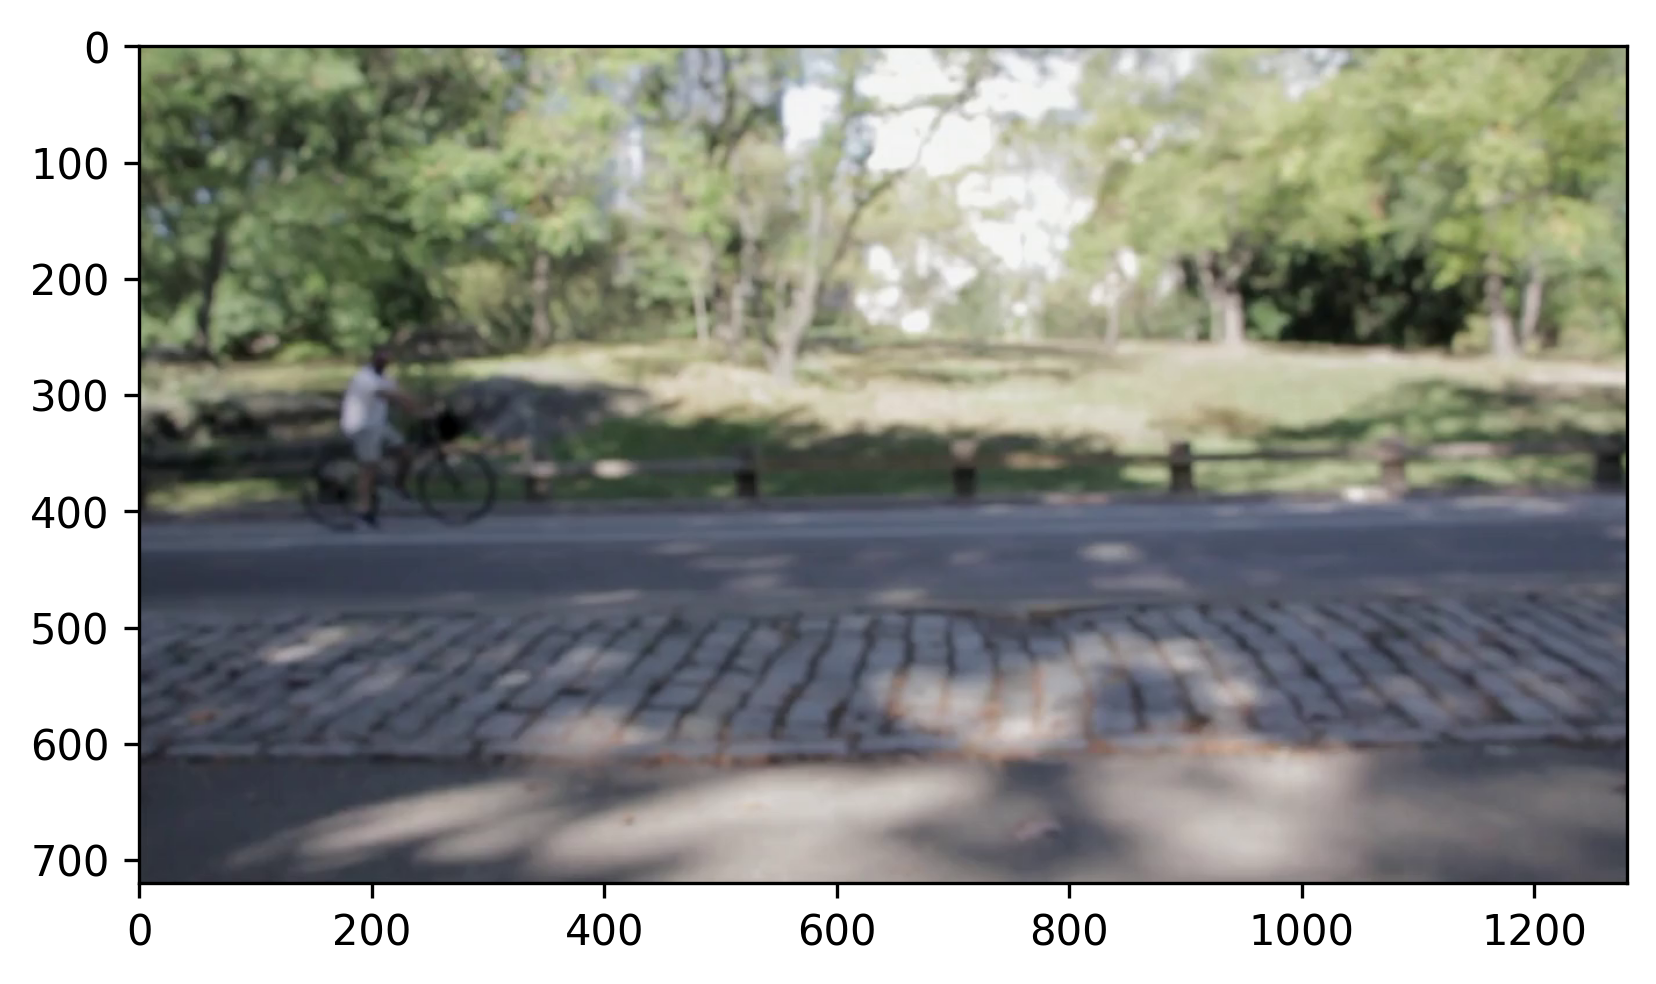

In [ ]:
# 背景画像として使用する最初のフレームを読み込み
video_src = VideoSrc(config)
drifting = video_src.read()

# 背景画像を確認表示
frame = drifting.img.copy()
plt.figure(dpi=300)
plt.imshow(frame[:,:,::-1])  # BGRからRGBに変換して表示
plt.show()

# 背景画像をbg_imgとして格納
bg_img = frame.copy()

In [ ]:
# 動画の入出力を準備
video_src = VideoSrc(config)              # 入力動画の読み込み
video_sink = VideoSink(video_src)         # 出力動画の設定

# 解析モジュールの準備
segmentation_classifier = SegmentationClassifier(conf=0.2)  # 物体検出モデル
detection_renderer = DetectionRenderer(
    segmentation_classifier.classnames,  # クラス名の設定
    bg_img                                       # 背景画像の設定
)

100%|██████████| 52.4M/52.4M [00:00<00:00, 96.1MB/s]


In [ ]:
#@title 公園の状況モニタリング

# フレームごとの処理を開始
for _ in tqdm(range(video_src.frame_count)):
    # 1. フレームの読み込み
    drifting = video_src.read()
    if drifting is None:  # 動画終了のチェック
        break

    # 2. セグメンテーションの実行
    drfiting = segmentation_classifier.predict(drifting)

    # 3. 検出結果の描画（シルエット表示）
    drifting = detection_renderer.draw(drifting)

    # 4. 結果の書き出し
    drifting = video_sink.write(drifting)

# 5. 終了処理
video_sink.release()

  0%|          | 0/348 [00:00<?, ?it/s]

count: 0 / 348
0: 384x640 1 person, 1 bicycle, 115.0ms
Speed: 17.3ms preprocess, 115.0ms inference, 829.5ms postprocess per image at shape (1, 3, 384, 640)
count: 1 / 348
0: 384x640 1 person, 1 bicycle, 31.0ms
Speed: 2.8ms preprocess, 31.0ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
count: 2 / 348
0: 384x640 1 person, 1 bicycle, 31.0ms
Speed: 2.5ms preprocess, 31.0ms inference, 2.4ms postprocess per image at shape (1, 3, 384, 640)
count: 3 / 348
0: 384x640 1 person, 1 bicycle, 31.0ms
Speed: 5.3ms preprocess, 31.0ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
count: 4 / 348
0: 384x640 1 person, 1 bicycle, 31.1ms
Speed: 2.3ms preprocess, 31.1ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 640)
count: 5 / 348
0: 384x640 1 person, 1 bicycle, 31.0ms
Speed: 1.9ms preprocess, 31.0ms inference, 1.9ms postprocess per image at shape (1, 3, 384, 640)
count: 6 / 348
0: 384x640 2 persons, 1 bicycle, 1 bench, 31.4ms
Speed: 2.1ms preprocess, 